##### For some actions, you may want to require human approval before running to ensure that everything is running as intended.

In [21]:
from typing import Annotated
import operator, json
from typing import TypedDict, Sequence
from typing_extensions import TypedDict

In [1]:
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults 

In [2]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [3]:
llm.invoke("hiii").content

'Hello! 👋 \n\nHow can I help you today? 😊\n'

In [5]:
@tool
def multiply(first_number: int, second_number : int ) -> int:
    "multiply two integer number"
    return first_number * second_number

In [6]:
multiply({"first_number":24,"second_number":364})

/tmp/ipykernel_18950/2089873997.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  multiply({"first_number":24,"second_number":364})


8736

In [7]:
multiply.invoke({"first_number":24,"second_number":364})

8736

In [8]:
@tool
def search(query: str):
    """Perform the web search on the user query"""
    tavily = TavilySearchResults()
    result = tavily.invoke(query)
    return result

In [9]:
search("who is a current president of USA?")

[{'title': 'Presidents, vice presidents, and first ladies | USAGov',
  'url': 'https://www.usa.gov/presidents',
  'content': "Learn about the duties of president, vice president, and first lady of the United States. Find out how to contact and learn more about current and past leaders.\n\nPresident of the United States\n\nThe president of the United States is the:\n\nCurrent president\n\nThe 47th and current president of the United States is Donald John Trump.\xa0He was sworn into office on January 20, 2025.\n\nFormer U.S. presidents [...] Read about past presidents and vice presidents.\n\nFirst lady\n\nThe First lady of the United States has traditionally been the wife or other close female relative of the president of the United States. First ladies:\n\nCurrent first lady\n\nThe current first lady of the United States is Melania Trump.\n\nFormer first ladies\n\nFind a list of former first ladies and their presidential spouses.\n\nSee the Smithsonian Institution's virtual tour of firs

In [10]:
tools=[search,multiply]

In [11]:
model_with_tools = llm.bind_tools(tools)

In [12]:
tool_mapping={tool.name: tool for tool in tools}
tool_mapping

{'search': StructuredTool(name='search', description='Perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x7733f4280fe0>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x7733f4874cc0>)}

In [13]:
response = model_with_tools.invoke("who is a current president of india")

In [14]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_s4x0', 'function': {'arguments': '{"query":"who is the current president of india"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 1075, 'total_tokens': 1161, 'completion_time': 0.156363636, 'prompt_time': 0.038041581, 'queue_time': 0.24521798, 'total_time': 0.194405217}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6ba5dcbb-b9fb-4af3-934d-e5b38110f021-0', tool_calls=[{'name': 'search', 'args': {'query': 'who is the current president of india'}, 'id': 'call_s4x0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1075, 'output_tokens': 86, 'total_tokens': 1161})

In [15]:
tool_details=response.additional_kwargs.get("tool_calls")

In [16]:
tool_details

[{'id': 'call_s4x0',
  'function': {'arguments': '{"query":"who is the current president of india"}',
   'name': 'search'},
  'type': 'function'}]

In [17]:
tool_details[0]["function"]["name"]

'search'

In [19]:
tool_details[0]['function']['arguments']

'{"query":"who is the current president of india"}'

In [22]:
json.loads(tool_details[0]['function']['arguments'])

{'query': 'who is the current president of india'}

In [23]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [24]:
def invoke_model(state:AgentState):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]}

In [25]:
def invoke_tool(state:AgentState):
    tool_details= state['messages'][-1].additional_kwargs.get("tool_calls", [])[0]
    
    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f'Selected tool: {tool_details.get("function").get("name")}')
    
    if tool_details.get("function").get("name")=="search":
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise Exception("web search discard")
        
    response = tool_mapping[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return {"messages" : [response]}

In [26]:
def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "tool"
    else:
        return "end"

In [27]:
graph = StateGraph(AgentState) ### StateGraph with AgentState

graph.add_node("ai_assistant", invoke_model)

graph.add_node("tool", invoke_tool)

In [28]:
graph.add_conditional_edges("ai_assistant", router, {"tool": "tool","end": END,})

graph.add_edge("tool", END)

#graph.add_edge("tool", "ai_assistant")

graph.set_entry_point("ai_assistant")

In [29]:
app = graph.compile()

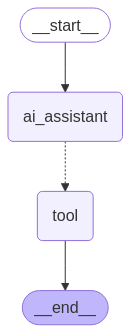

In [30]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [31]:
for s in app.stream({"messages": ["who is upcoming president of India?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0tej', 'function': {'arguments': '{"query":"upcoming president of India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 1075, 'total_tokens': 1157, 'completion_time': 0.149090909, 'prompt_time': 0.039180016, 'queue_time': 0.253923025, 'total_time': 0.188270925}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bf8c151a-afd0-4f3b-9b3c-d3369df28d0c-0', tool_calls=[{'name': 'search', 'args': {'query': 'upcoming president of India'}, 'id': 'call_0tej', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1075, 'output_tokens': 82, 'total_tokens': 1157})]}
----
Selected tool: search
{'messages': [[{'title': 'President of India - Wikipedia', 'url': 'https://en.wikipedia.org/wiki/President_of_India', 'content': 'India portalOther countries\nvte\nThe president

In [32]:
for s in app.stream({"messages": ["what is multiplication of 23 and 46?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xt8w', 'function': {'arguments': '{"first_number":23,"second_number":46}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 93, 'prompt_tokens': 1080, 'total_tokens': 1173, 'completion_time': 0.169090909, 'prompt_time': 0.047054787, 'queue_time': 0.25232196, 'total_time': 0.216145696}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f0c32367-c83d-4af4-b89b-415d8ede9403-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 23, 'second_number': 46}, 'id': 'call_xt8w', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1080, 'output_tokens': 93, 'total_tokens': 1173})]}
----
Selected tool: multiply
{'messages': [1058]}
----


##### LangGraph supports human-in-the-loop workflows in a number of ways. In this section, we will use LangGraph's interrupt_before functionality to always break the tool node.

In [33]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

In [35]:
tavily=TavilySearchResults()
tools = [tavily]

In [36]:
llm_with_tools = llm.bind_tools(tools)

In [37]:
def ai_assistant(state: AgentState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [38]:
memory = MemorySaver()

In [39]:
graph_builder = StateGraph(AgentState)
graph_builder.add_node("ai_assistant", ai_assistant)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [40]:
graph_builder.add_edge(START, "ai_assistant")

graph_builder.add_conditional_edges(
    "ai_assistant",
    tools_condition,
)
graph_builder.add_edge("tools", "ai_assistant")

In [41]:
app2 = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

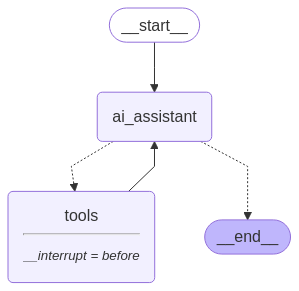

In [42]:
from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

In [43]:
user_input = "what is current a capital of india?"
config = {"configurable": {"thread_id": "1"}}

In [44]:
# The config is the **second positional argument** to stream() or invoke()!
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [45]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what is current a capital of india?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_vbnq)
 Call ID: call_vbnq
  Args:
    query: capital of india


In [46]:
snapshot = app2.get_state(config)

In [47]:
snapshot.next

('tools',)

In [48]:
last_message=snapshot.values["messages"][-1]

In [49]:
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'capital of india'},
  'id': 'call_vbnq',
  'type': 'tool_call'}]

In [52]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = app2.stream(None, config, stream_mode="values")

In [53]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_r3xr)
 Call ID: call_r3xr
  Args:
    query: capital of india
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "What is the capital of India? States and union territories explained.", "url": "https://www.usatoday.com/story/news/world/2023/05/24/what-is-the-capital-of-india/70195720007/", "content": "The capital of India is New Delhi, located in the north-central part of the country to the west of the Yamuna River. Calcutta (now Kolkata, the", "score": 0.9014448}, {"title": "New Delhi - Wikipedia", "url": "https://en.wikipedia.org/wiki/New_Delhi", "content": "New Delhi (/ˈnjuː ˈdɛ.li/ ⓘ,[6] Hindi: [ˈnəiː ˈdɪlːiː], ISO: Naī Dillī) is the capital of India and a part of the National Capital Territory of Delhi (NCT). New Delhi is the seat of all three branches of the Government of India, h

In [54]:
user_input = "what is a weather there?"

config = {"configurable": {"thread_id": "1"}}

In [55]:
# The config is the **second positional argument** to stream() or invoke()!
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [56]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what is a weather there?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_246b)
 Call ID: call_246b
  Args:
    query: weather in new delhi


In [57]:
snapshot = app2.get_state(config)

In [58]:
snapshot.next

('tools',)

In [59]:
last_message=snapshot.values["messages"][-1]

In [60]:
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'weather in new delhi'},
  'id': 'call_246b',
  'type': 'tool_call'}]

In [61]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = app2.stream(None, config, stream_mode="values")

In [62]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_246b)
 Call ID: call_246b
  Args:
    query: weather in new delhi
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "maximum and minimum temperatures - New Delhi", "url": "https://rmcnewdelhi.imd.gov.in/press/press.php", "content": "Dated:02-05-2025. Forecast Valid for:03-05-2025. LOCAL WEATHER FORECAST OF DELHI. Forecast: GENERALLY CLOUDY SKY. VERY LIGHT TO LIGHT RAIN. THUNDERSTORM", "score": 0.9471519}, {"title": "New Delhi Weather Forecast 3 May 2025 - Times of India", "url": "https://timesofindia.indiatimes.com/weather/new-delhi-weather-forecast-today/110011", "content": "Today's Weather in New Delhi: In New Delhi today, the weather is expected to be Haze with a maximum temperature of 29°C and a minimum of 24°C. Sunrise in", "score": 0.9393874}, {"title": "Delhi Weather Forecast fo

In [63]:
app2.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='what is current a capital of india?', additional_kwargs={}, response_metadata={}, id='5aaeaeca-1d5f-4d07-a3e6-fb2ba1bca5db'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vbnq', 'function': {'arguments': '{"query":"capital of india"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 989, 'total_tokens': 1078, 'completion_time': 0.161818182, 'prompt_time': 0.03466802, 'queue_time': 0.24630004200000002, 'total_time': 0.196486202}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c702855b-146b-4a3a-8155-aab4f8dfcb2f-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'capital of india'}, 'id': 'call_vbnq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 989, 'output_tokens': 89, 'total_tokens': 1078}), ToolMessage(c

In [64]:
snapshot=app2.get_state(config)

In [65]:
snapshot.next

()

In [66]:
user_input = "give me the recent news of it?"

config = {"configurable": {"thread_id": "1"}}

In [67]:
# The config is the **second positional argument** to stream() or invoke()!
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [68]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

give me the recent news of it?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_g2xb)
 Call ID: call_g2xb
  Args:
    query: recent news about new delhi


In [69]:
snapshot=app2.get_state(config)

In [70]:
current_message = snapshot.values["messages"][-1]

In [71]:
snapshot.next

('tools',)

In [72]:
current_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_g2xb)
 Call ID: call_g2xb
  Args:
    query: recent news about new delhi


In [73]:
tool_call_id = current_message.tool_calls[0]["id"] 

In [74]:
tool_call_id

'call_g2xb'

In [75]:
from langchain_core.messages import AIMessage, ToolMessage

In [76]:
answer = "it is just related to raining which is happing on daily basis"

In [77]:
new_messages = [
    ToolMessage(content=answer, tool_call_id=tool_call_id),
    AIMessage(content=answer),
]

In [78]:
app2.update_state(
    config,
    {"messages": new_messages},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0280f7-756b-68b8-800e-95eb0f52ff45'}}

In [79]:
print(app2.get_state(config).values["messages"][-1:])

[AIMessage(content='it is just related to raining which is happing on daily basis', additional_kwargs={}, response_metadata={}, id='cc54143c-d0d2-4247-bd0a-7ecb5eb137fd')]
